Train Cartpole Env with DQN
===========================

Let's now code the DQN algorithm introduced with the paper "Playing Atari games with Deep Reinforcement Learning", V. Minh et al., 2013, Nature

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Replay Buffer
Why it works: Instead of learning from the last action and forgetting it (which causes the "chasing its own tail" instability), we save experiences to a memory buffer. We then train on a random sample of past memories. This breaks the correlation between consecutive frames.

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (torch.tensor(states, dtype=torch.float32).to(device),
                torch.tensor(actions, dtype=torch.int64).to(device),
                torch.tensor(rewards, dtype=torch.float32).to(device),
                torch.tensor(next_states, dtype=torch.float32).to(device),
                torch.tensor(dones, dtype=torch.float32).to(device))
    
    def __len__(self):
        return len(self.buffer)

# The Neural network (DQN)
A simple network that takes the State (4 inputs) and outputs the Q-Value for each Action (Left/Right).

In [3]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Epsilon-Greedy Action Selection

This function handles the trade-off between Exploration (random action) and Exploitation (using the network's knowledge).

In [4]:
def select_action(model, state, epsilon, action_dim):
    # Exploration: random action
    if random.random() < epsilon:
        return random.randrange(action_dim)
    
    # Exploitation: best action according to the network
    with torch.no_grad():
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        return int(model(state_t).argmax(1).item())

# Initialization & Target Network

Why it works: We use two networks.

Policy Net: The one we train at every step.

Target Net: A frozen copy used to calculate the future reward target. This provides a stable target for the loss function, preventing the training from oscillating wildly.

In [5]:
# Hyperparameters
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize Networks
policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)

# Copy weights from Policy to Target and freeze Target
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)


# Training loop

In [7]:
# Hyperparameters

episodes = 1500
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99
target_update = 10
buffer_capacity = 10000
min_buffer_size = 1000
rewards_history = []
loss_history = []


buffer = ReplayBuffer(buffer_capacity)

# 
def plot_smoothed(data, title, ylabel, window_size=50):
    # Calcolo della media mobile (Moving Average)
    smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(12, 5))
    # Plot dati originali (trasparenti)
    plt.plot(data, label='Raw', alpha=0.3, color='gray')
    # Plot dati 'lisciati' (solidi)
    plt.plot(range(window_size-1, len(data)), smoothed, label=f'Smoothed (MA {window_size})', linewidth=2)
    
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Training started...
Episode 0, Reward: 10.0, Avg Loss: 0.0000, Epsilon: 0.99
Episode 50, Reward: 13.0, Avg Loss: 0.0000, Epsilon: 0.60
Episode 100, Reward: 124.0, Avg Loss: 0.0784, Epsilon: 0.36
Episode 150, Reward: 167.0, Avg Loss: 0.0834, Epsilon: 0.22
Episode 200, Reward: 132.0, Avg Loss: 0.1910, Epsilon: 0.13
Episode 250, Reward: 120.0, Avg Loss: 0.0608, Epsilon: 0.08
Episode 300, Reward: 230.0, Avg Loss: 0.0895, Epsilon: 0.05
Episode 350, Reward: 204.0, Avg Loss: 0.0329, Epsilon: 0.03
Episode 400, Reward: 203.0, Avg Loss: 0.0344, Epsilon: 0.02
Episode 450, Reward: 133.0, Avg Loss: 1.0715, Epsilon: 0.01
Episode 500, Reward: 204.0, Avg Loss: 0.3930, Epsilon: 0.01
Episode 550, Reward: 135.0, Avg Loss: 1.0877, Epsilon: 0.01
Episode 600, Reward: 500.0, Avg Loss: 1.0540, Epsilon: 0.01
Episode 650, Reward: 500.0, Avg Loss: 2.3667, Epsilon: 0.01
Episode 700, Reward: 118.0, Avg Loss: 1.4940, Epsilon: 0.01
Episode 750, Reward: 202.0, Avg Loss: 2.2305, Epsilon: 0.01
Episode 800, Reward: 309.

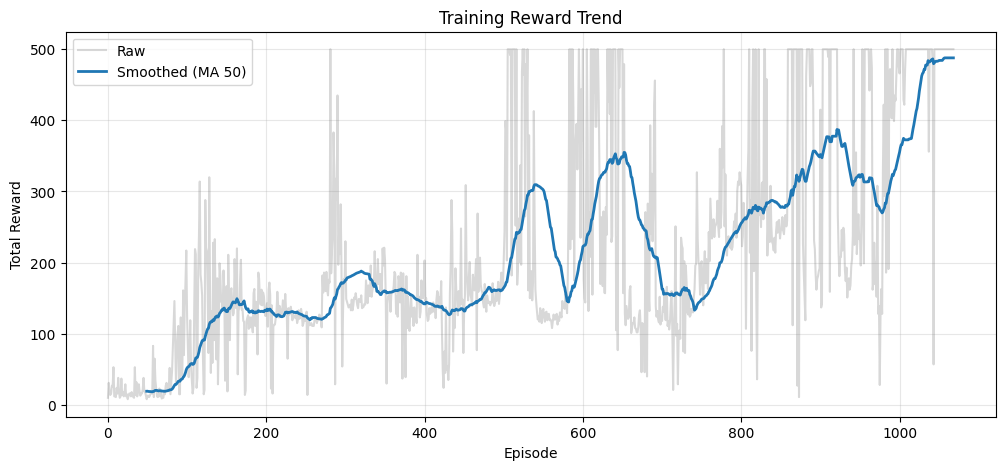

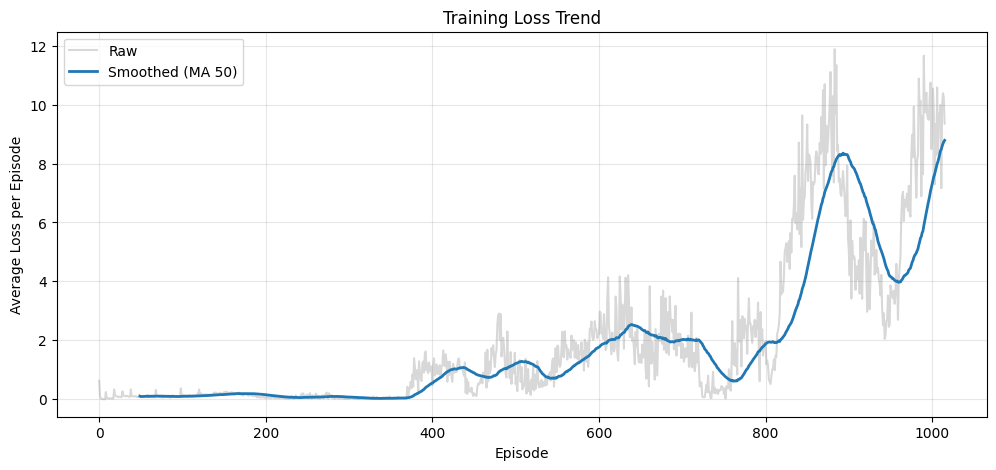

In [8]:
print("Training started...")
for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    # Per calcolare la loss media di QUESTO episodio
    episode_loss = [] 

    while not done:
        action = select_action(policy_net, state, epsilon, action_dim)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(buffer) > min_buffer_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            
            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0]
                target = rewards + gamma * max_next_q * (1 - dones)
            
            current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = nn.MSELoss()(current_q, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Salviamo la loss dello step corrente
            episode_loss.append(loss.item()) 

    # Update Target Net
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Salviamo i dati storici
    rewards_history.append(total_reward)
    # Se abbiamo fatto training in questo episodio, salviamo la media, altrimenti 0
    loss_history.append(np.mean(episode_loss) if episode_loss else 0)
    
    if episode % 50 == 0:
        print(f"Episode {episode}, Reward: {total_reward}, Avg Loss: {loss_history[-1]:.4f}, Epsilon: {epsilon:.2f}")

    # Early Stopping: se la media degli ultimi 30 episodi è alta, ci fermiamo
    if len(rewards_history) >= 30:
        avg_reward = np.mean(rewards_history[-100:])
        if avg_reward >= 440.0:  # Soglia per considerare CartPole "risolto"
            print(f"✅ Solved at episode {episode}! Average Reward: {avg_reward:.2f}")
            break

print("Training finished.")

# 1. Plot dei Reward
plot_smoothed(rewards_history, "Training Reward Trend", "Total Reward")

# 2. Plot della Loss
# Filtriamo i primi episodi dove la loss è 0 perché il buffer non era pieno
valid_loss = [l for l in loss_history if l > 0]
if valid_loss:
    plot_smoothed(valid_loss, "Training Loss Trend", "Average Loss per Episode")

# Visualizing the trained Policy

In [9]:

# Creiamo un ambiente dedicato al rendering
vis_env = gym.make('CartPole-v1', render_mode='human')
state, _ = vis_env.reset()
done = False

print("Visualizing trained agent...")

test_episodes = 3
for _ in range(test_episodes):
    state, _ = vis_env.reset()
    done = False
    total_test_reward = 0

    while not done:
        action = select_action(policy_net, state, 0, action_dim)  # epsilon=0 per sfruttare solo la conoscenza appresa
        state, reward, terminated, truncated, _ = vis_env.step(action)
        done = terminated or truncated
        total_test_reward += reward

    print(f"Test Episode Reward: {total_test_reward}")


/Users/albertovaglio/Desktop/DQN/dqn_env/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Visualizing trained agent...
Test Episode Reward: 500.0
Test Episode Reward: 500.0


KeyboardInterrupt: 